<a href='https://github.com/SeWonKwon' ><div> <img src ='https://slid-capture.s3.ap-northeast-2.amazonaws.com/public/image_upload/6556674324ed41a289a354258718280d/964e5a8b-75ad-41fc-ae75-0ca66d06fbc7.png' align='left' /> </div></a>


In [1]:
# 필요 라이브러리 import
import warnings
warnings.filterwarnings('ignore')


In [2]:
import gdown
import os
def get_human_dataset():

    google_path = 'https://drive.google.com/uc?id='
    file_id_train = '16dVeNybWyjHnucmeIuLtzfdX2qFZSUEG'
    file_id_test = '1WFAOJNz8Ovj2olAHB_TvSHbjUN-zDIQU'

    gdown.download(google_path+file_id_train,'human_train.csv',quiet=False)
    gdown.download(google_path+file_id_test,'human_test.csv',quiet=False)
    
    X_train = pd.read_csv('human_train.csv')
    X_test = pd.read_csv('human_test.csv')
    y_train = X_train.iloc[:,-1]
    y_test = X_test.iloc[:, -1]
    X_train = X_train.iloc[:,:-1]
    X_test = X_test.iloc[:,:-1]
    
    os.remove('human_train.csv')
    os.remove('human_test.csv')
    
    return X_train, X_test, y_train, y_test


In [3]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score

def plot_conf_mat(conf_mat):
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center',fontsize=19)
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()
    
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    plot_conf_mat(confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1_score:{3:.4f},\
            AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# Voting, Bagging, Boosting, Stacking

* 방식별 주요 구분점
|유형|방식|
|:-:|:-|
|Voting|서로 다른 알고리즘을 가진 분류기의 결합|
|Bagging|같은 알고리즘이지만, 서로 다른  데이터 샘플링|
|Boosting|여러개의 분류기의 순차적 학습 수행|
|Stacking| | 

# Voting & Bagging

분류기가 투표를 통해 최종 예측 결과를 결정하는 방식

<div> <img src='https://media.vlpt.us/images/jiselectric/post/49803ffd-d915-403f-8c78-9fe5ee26ad1d/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-14%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%201.02.01.png' width='500'/> 출처 : 파이썬 완벽 가이드</div>

**Voting**

* Generally combine different classifiers
* Classifiers use identical dataset

**Bagging**

* Generally use identical classifiers
* Classifiers use different datasets

## Voting 

### Voting 유형
1. 하드보팅 - Hard voting은 다수의 classifier의 예측 결과값을 다수결로 최종 class를 결정한다.
2. 소프트보팅 - Soft voting은 다수의 classifier의 예측 결과값간 확률을 평균하여 최종 class를 결정한다.

- 일반적으로 Soft voting이 성능이 우수하여 주로 사용된다. 


<div><img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcvYig2%2FbtqKsojGyfl%2FiKazMxfc8GKeWa1OHYjHH0%2Fimg.png' width='500' /><br> 출처 : 파이썬 완변 가이드</div>

>하드보팅: 1 , 2 , 1, 1 --> 1: 3, 2:1 --> 최종값 `1`   
>소프트보팅: 1: (0.7 + 0.2 + 0.8 + 0.9) / 4, 2:(0.3 + 0.8 + 0.2 + 0.1 ) / 4 --> 1: 0.65, 2: 0.35 --> 최종값:`1`

### Voting Classifier 

In [4]:
# 데이터 셋팅및 import & 로드
import pandas as pd 

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

cancer = load_breast_cancer()
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(2)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [5]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2, random_state=156)

보팅 모델 구성

* 실제로 구성을 해보면, 여러개의 모델을 같이 구성하는 것이기 때문에 , 다양한 오류가 발생한다.

* 오류를 모델별로 해결 하지 않으면 작동 하지 않을수 있다. 

* 밑에 보면 model 설정에, `solver=`, `probability=`등은 수정을 위해서 설정한 것임

In [6]:
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(solver='liblinear')
model2 = KNeighborsClassifier()
model3 = SVC(probability=True)

voting_clf = VotingClassifier(estimators=[('LR', model1),
                                         ('KNN', model2),
                                         ('SVM', model3)],
                              
                             voting='hard')

In [7]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('LR', LogisticRegression(solver='liblinear')),
                             ('KNN', KNeighborsClassifier()),
                             ('SVM', SVC(probability=True))])

In [8]:
pred = voting_clf.predict(X_test)

In [9]:
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9474


In [10]:
models = [model1, model2, model3, voting_clf]
for model in models:
    scores = cross_val_score(model, cancer.data, cancer.target, cv=5)
    model_name = str(type(model)).split('.')[-1][:-2]
    print('Accuracy: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), model_name))
    

Accuracy: 0.95 (+/- 0.01) [LogisticRegression]
Accuracy: 0.93 (+/- 0.02) [KNeighborsClassifier]
Accuracy: 0.91 (+/- 0.04) [SVC]
Accuracy: 0.93 (+/- 0.03) [VotingClassifier]


결과를 보면 SVC 가 상당히 낮게 노이기 때문에 SVC 대신에 RandomForest를 넣어 보겠다. 

In [11]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

model1 = LogisticRegression(solver='liblinear')
model2 = KNeighborsClassifier()
model3 = RandomForestClassifier()

voting_clf = VotingClassifier(estimators=[('LR', model1),
                                         ('KNN', model2),
                                         ('RF', model3)],
                              
                             voting='soft')

In [12]:
models = [model1, model2, model3, voting_clf]
for model in models:
    scores = cross_val_score(model, cancer.data, cancer.target, cv=5)
    model_name = str(type(model)).split('.')[-1][:-2]
    print('Accuracy: %0.4f (+/- %0.4f) [%s]' % (scores.mean(), scores.std(), model_name))

Accuracy: 0.9526 (+/- 0.0142) [LogisticRegression]
Accuracy: 0.9279 (+/- 0.0218) [KNeighborsClassifier]
Accuracy: 0.9596 (+/- 0.0189) [RandomForestClassifier]
Accuracy: 0.9561 (+/- 0.0184) [VotingClassifier]


역시 RandomForest가 가장 잘나온다. 그렇다면 RandomForest를 2개 넣고, KNN 을 제거해 보자
* 2개를 넣을때는 estimator 이름을 서로 다르게 해야 한다. 

In [13]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

model1 = LogisticRegression(solver='liblinear')
model2 = RandomForestClassifier()
model3 = RandomForestClassifier()

voting_clf = VotingClassifier(estimators=[('LR', model1),
                                         ('RF', model2),
                                         ('RF2', model3)],
                              
                             voting='soft')

In [14]:
models = [model1, model2, model3, voting_clf]
for model in models:
    scores = cross_val_score(model, cancer.data, cancer.target, cv=5)
    model_name = str(type(model)).split('.')[-1][:-2]
    print('Accuracy: %0.4f (+/- %0.4f) [%s]' % (scores.mean(), scores.std(), model_name))

Accuracy: 0.9526 (+/- 0.0142) [LogisticRegression]
Accuracy: 0.9631 (+/- 0.0210) [RandomForestClassifier]
Accuracy: 0.9561 (+/- 0.0277) [RandomForestClassifier]
Accuracy: 0.9666 (+/- 0.0151) [VotingClassifier]


human_set() 해봤는데 잘나옮~

In [15]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

model1 = LogisticRegression(solver='liblinear')
model2 = RandomForestClassifier()
model3 = RandomForestClassifier()

voting_clf = VotingClassifier(estimators=[('LR', model1),
                                         ('RF', model2),
                                         ('RF2', model3)],
                              
                             voting='soft')

In [16]:
X_train, X_test, y_train, y_test = get_human_dataset()

Downloading...
From: https://drive.google.com/uc?id=16dVeNybWyjHnucmeIuLtzfdX2qFZSUEG
To: C:\Users\bigne\OneDrive\WorkJ\Machine Learning\Machine_Learning\human_train.csv
48.1MB [00:02, 17.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WFAOJNz8Ovj2olAHB_TvSHbjUN-zDIQU
To: C:\Users\bigne\OneDrive\WorkJ\Machine Learning\Machine_Learning\human_test.csv
19.3MB [00:01, 15.8MB/s]


In [17]:
models = [model1, model2, model3, voting_clf]
for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    model_name = str(type(model)).split('.')[-1][:-2]
    print('Train Accuracy: %0.4f (+/- %0.4f) [%s]' % (scores.mean(), scores.std(), model_name))

Train Accuracy: 0.9381 (+/- 0.0272) [LogisticRegression]
Train Accuracy: 0.9172 (+/- 0.0192) [RandomForestClassifier]
Train Accuracy: 0.9168 (+/- 0.0167) [RandomForestClassifier]
Train Accuracy: 0.9392 (+/- 0.0202) [VotingClassifier]


* `hard`보다는 `soft`가 비교적 잘나온다. 
* 가중치를 줌으로서 조정 가능하다. 

수동으로 웨이트 부여

In [20]:
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

model1 = LogisticRegression(solver='liblinear')
model2 = RandomForestClassifier()
model3 = DecisionTreeClassifier()

voting_clf = VotingClassifier(estimators=[('LR', model1),
                                         ('RF', model2),
                                         ('DT', model3)],
                              
                             voting='soft')

voting_clf2 = VotingClassifier(estimators=[('LR', model1),
                                         ('RF', model2),
                                         ('DT', model3)],
                              
                             voting='soft',
                             weights=np.random.randint(1,2,3))

voting_clf3 = VotingClassifier(estimators=[('LR', model1),
                                         ('RF', model2),
                                         ('DT', model3)],
                              
                             voting='soft',
                             weights=np.random.randint(1,2,3))

voting_clf4 = VotingClassifier(estimators=[('LR', model1),
                                         ('RF', model2),
                                         ('DT', model3)],
                              
                             voting='soft',
                             weights=np.random.randint(1,2,3))


In [21]:
models = [voting_clf, voting_clf2, voting_clf3, voting_clf4]
for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    model_name = str(type(model)).split('.')[-1][:-2]
    print('Train Accuracy: %0.4f (+/- %0.4f) [%s]' % (scores.mean(), scores.std(), model_name))

Train Accuracy: 0.9106 (+/- 0.0276) [VotingClassifier]
Train Accuracy: 0.9052 (+/- 0.0305) [VotingClassifier]
Train Accuracy: 0.9051 (+/- 0.0267) [VotingClassifier]
Train Accuracy: 0.9070 (+/- 0.0269) [VotingClassifier]


## Bagging

* 동일한 알고리즘을 다르게 샘플링한 데이터 셋으로 훈련후에 결합하여 생긴 결과    


* 샘플을 여러 번 뽑아각 모델을 학습시켜 결과를 집계(Aggregating)하는 방법   
  
  
* Bagging이 병렬로 학습


* 대상 데이터로부터 복원 랜덤 샘플링 한 후 이렇게 추출한 데이터가 일종의 표본집단 >> 이 결과로 모델을 생성해낸다.



* 배깅은 각 샘플에서 나타난 결과를 일종의 중간값으로 맞추어주기 때문에 분산을 줄이고 overfitting을 피할 수 있다.



* 부트스트랩 방법을 이용해 학습데이터에서 m개의 복원 추출을 B회만큼 반복, 병렬로 학습



* 각각의 학습 데이터로 학습하면서 약학습기 h를 구축한 후 통합하면 학습기 H가 된다.



* H는 학습 데이터의 식별이나 확인에는 가장 우수한 결과를 선택하며 회귀일때는 h의 평균을 이용



* 대표적으로 DecisionTree베이스의 RandomForest 가 주로 쓰이며, 다른 알고리즘도 사용가능하다.

### Bootstraping

* Term Bagging is derived from boostrap aggregating.
* 단순랜덤 복원 추출 방법을 활용

* 샘플에 한번도 선택되지 않는 원 데이터가 발생할 수 있는 확률 : **36.8%**
* 뽑히지 않은 데이터를 Test sets에 넣어서 활용

<img src='https://media.vlpt.us/images/jiselectric/post/df95b0d0-08ac-4457-8d86-b06bfd75c8bc/bootrap_concept.png' width='500'/>

### RandomForest

* DecisionTree알고리즘의 Bagging : RandomForest    

   
* 변수를 랜덤으로 선택

human_dataset으로 테스트

In [22]:
X_train, X_test, y_train, y_test = get_human_dataset()

Downloading...
From: https://drive.google.com/uc?id=16dVeNybWyjHnucmeIuLtzfdX2qFZSUEG
To: C:\Users\bigne\OneDrive\WorkJ\Machine Learning\Machine_Learning\human_train.csv
48.1MB [00:01, 30.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WFAOJNz8Ovj2olAHB_TvSHbjUN-zDIQU
To: C:\Users\bigne\OneDrive\WorkJ\Machine Learning\Machine_Learning\human_test.csv
19.3MB [00:01, 11.7MB/s]


In [23]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
default_score = accuracy_score(y_test, pred)
default_score

0.9267051238547676

GridsearchCV 를 활용해서 파라미터 튜닝을 해보자. 

1. n_estimators:결정 트리의 개수 지정, 많이 설정할수록 좋은 성능 기대,but 수행시간이 오래 걸림
2. max_features: 'auto' = 'sqrt', 트리 분할할는 피처를 참조할때, 전체가 아니라 sqrt(전체)만큼(16개라면 4개)
3. max_depth or min_samples_leaf: 과적합 개선을 위해서

In [24]:
from sklearn.model_selection import GridSearchCV
from multiprocessing import cpu_count
rf_clf = RandomForestClassifier()
rf_clf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [25]:
param_grid = {\
          'n_estimators':[100],
          'max_depth' : [6, 8, 10, 12], 
          'min_samples_leaf' : [8, 12, 18 ],
          'min_samples_split' : [8, 16, 20]
         }

grid_cv = GridSearchCV(estimator=rf_clf,
                  param_grid=param_grid,
                  cv = 5, 
                  n_jobs=cpu_count(),
                  verbose=True
              )
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   16.9s
[Parallel(n_jobs=12)]: Done 180 out of 180 | elapsed:  1.4min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=12,
             param_grid={'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [8, 12, 18],
                         'min_samples_split': [8, 16, 20],
                         'n_estimators': [100]},
             verbose=True)

In [26]:
print('디펄트 정확도', default_score)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

디펄트 정확도 0.9267051238547676
최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9272


In [27]:
grid_cv.cv_results_

{'mean_fit_time': array([4.28152623, 4.27772269, 4.28070545, 4.26788063, 4.29190249,
        4.25426807, 4.2690814 , 4.23264861, 4.19121089, 5.21354051,
        5.14147511, 5.17650661, 5.06580601, 5.06220288, 5.09335012,
        4.94397211, 4.95995049, 4.97215385, 5.72066054, 5.71047111,
        5.72066984, 5.56893249, 5.52068739, 5.55733337, 5.28625917,
        5.35873046, 5.27545362, 6.01634274, 5.92015314, 6.00463996,
        5.70765061, 5.75031133, 5.72308135, 5.50087619, 5.44840121,
        5.32206588]),
 'std_fit_time': array([0.02146367, 0.03790471, 0.0508272 , 0.0262384 , 0.05015369,
        0.0247175 , 0.07341891, 0.06171776, 0.01623368, 0.03847625,
        0.03536718, 0.05335301, 0.02043806, 0.03981334, 0.02820067,
        0.03675789, 0.0615498 , 0.03789501, 0.05829607, 0.07393409,
        0.04006054, 0.02702763, 0.04777873, 0.06094832, 0.03958925,
        0.04450834, 0.04174317, 0.10008999, 0.06528102, 0.07758152,
        0.05250943, 0.09802883, 0.07757995, 0.06474503, 0.047

In [28]:
best_rf_clf = grid_cv.best_estimator_
pred = best_rf_clf.predict(X_test)
print('테스트set 정확도',accuracy_score(y_test, pred))

테스트set 정확도 0.9172039362063115


시각화

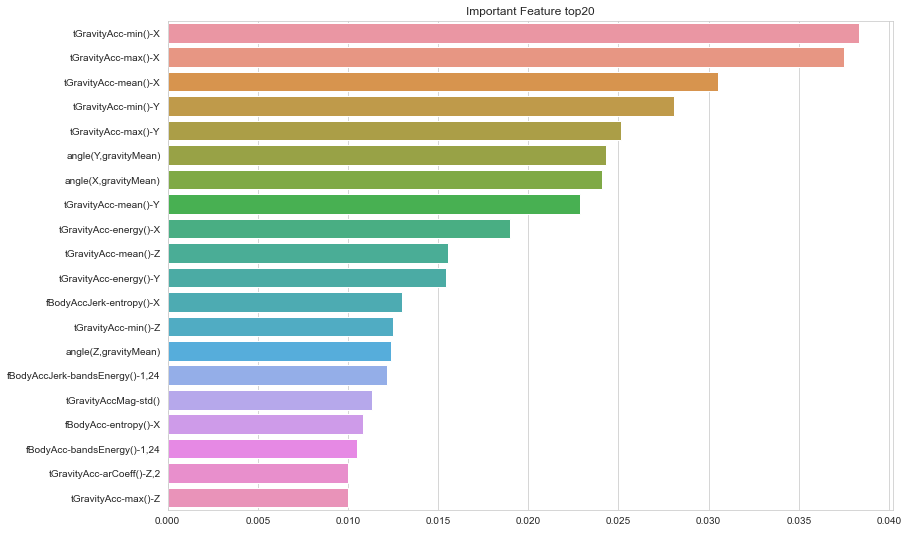

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

best_feature = pd.Series(best_rf_clf.feature_importances_, index = X_train.columns)
best_f_top20 = best_feature.sort_values(ascending=False)[:20]

plt.figure(figsize=(13, 9))
sns.barplot(x=best_f_top20, y = best_f_top20.index)
plt.title('Important Feature top20')
plt.show();

### BaggingClassifier

* RandomForest 는 배깅의 대표 알고리즘이다. 

* 위에서 보면 Logistic을 활용해서 배깅을 구성한후에 RandomForest 모델과 비교해 보자.

In [30]:
X_train, X_test, y_train, y_test = get_human_dataset()

Downloading...
From: https://drive.google.com/uc?id=16dVeNybWyjHnucmeIuLtzfdX2qFZSUEG
To: C:\Users\bigne\OneDrive\WorkJ\Machine Learning\Machine_Learning\human_train.csv
48.1MB [00:01, 42.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WFAOJNz8Ovj2olAHB_TvSHbjUN-zDIQU
To: C:\Users\bigne\OneDrive\WorkJ\Machine Learning\Machine_Learning\human_test.csv
19.3MB [00:01, 11.6MB/s]


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

base_model = LogisticRegression(solver='liblinear')

In [32]:
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier( base_model, n_estimators=10,
                                   max_samples=0.5, max_features=0.5)

bagging_model.fit(X_train_trans, y_train)
pred = bagging_model.predict(X_test_trans)

In [33]:
default_score = accuracy_score(y_test, pred)
default_score

0.9558873430607397

* Random Forest 보다  좋은 점수를 가지고 있다. 
* gridSearchCV로 하이퍼 파라미터 튜닝을 해보자.  

In [34]:
bagging_model = BaggingClassifier(base_model)

param_grid = {'n_estimators':[10],
              'max_samples':[0.4, 0.5, 0.6],
              'max_features':[0.4, 0.5, 0.7],
              }

grid_cv = GridSearchCV(estimator=bagging_model,
                       param_grid=param_grid,
                       cv=5,
                       n_jobs=-1,
                       verbose=True)

grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.7min finished


GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear')),
             n_jobs=-1,
             param_grid={'max_features': [0.4, 0.5, 0.7],
                         'max_samples': [0.4, 0.5, 0.6], 'n_estimators': [10]},
             verbose=True)

In [35]:
print('디펄트 정확도', default_score)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

디펄트 정확도 0.9558873430607397
최적 하이퍼 파라미터:
 {'max_features': 0.7, 'max_samples': 0.4, 'n_estimators': 10}
최고 예측 정확도: 0.9355


In [36]:
best_rf_clf = grid_cv.best_estimator_
pred = best_rf_clf.predict(X_test)
print('테스트set 정확도',accuracy_score(y_test, pred))

테스트set 정확도 0.9586019681031558


* GridSearchCV로 성능 향상은 안되었지만, 랜덤 포레스트보다 좋은 결과를 보여준다.

시각화를 한번 해봅시다. 위에서 랜덤 포레스트와 비교해서 feature_importance를 계산해 봅시다. 
* feature_importance를 계산하기 위해서는 model.coef_가 필요 하기 때문에 위의 grid_cv.best_parmas_ 결과를 가지고 다시 모델을 수행후에 구해야 합니다. 

In [37]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

In [38]:
Bag_lg_clf = BaggingClassifier(LogisticRegression(solver='liblinear'),max_features= 0.5, max_samples= 0.6)
Bag_lg_clf.fit(X_train_trans, y_train)

BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear'),
                  max_features=0.5, max_samples=0.6)

In [39]:
pred = Bag_lg_clf.predict(X_test_trans)
accuracy_score(y_test, pred)

0.9494401085850017

In [40]:
import numpy as np
feature_coef = np.mean([
    model.coef_ for model in Bag_lg_clf.estimators_
], axis=0)

feature_coef.shape

(6, 281)

In [41]:
 for model in Bag_lg_clf.estimators_:
    print(model.classes_)

[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


배깅 모델의 임포턴스를 구하는 것은 조금더 생각해봐야 겠따. 
전체의 feature가 나오는 것이 아니기 때문에 위와 같이 나오기는 하는데 결과를 시각적으로 보기는 쉽지 않다. 
어떤 피쳐가 어떤 것인지 알수가 없으므로

# Boosting

<img src='https://miro.medium.com/max/2000/1*zTgGBTQIMlASWm5QuS2UpA.jpeg' width='500' />https://miro.medium.com/max/2000/1*zTgGBTQIMlASWm5QuS2UpA.jpeg

* 순차적으로 틀린 문제에 대하여 가중치를 부여함으로써 모델을 개선해 나가는 방식

* 맞추기 어려운 문제를 맞추는데 초점이 되어 있음. 가중치 부여를 통해서

* 순차적으로 학습, 배깅과 마찬가지로 동일하게 복원 랜덤 샘플링을 하지만 가중치를 부여 오답에 대해 높은 가중치를 부여하고, 정답에 대해 낮은 가중치를 부여하기 때문에 오답에 더욱 집중할 수 있다.

* 단점, 그만큼 Outlier에 취약하다. 

## Adaboost vs GBM

가중치를 부여하는 방식의 차이 

Adaboost
<img src='https://www.researchgate.net/profile/Zhuo-Wang-36/publication/288699540/figure/fig9/AS:668373486686246@1536364065786/Illustration-of-AdaBoost-algorithm-for-creating-a-strong-classifier-based-on-multiple.png' width='500' />https://www.researchgate.net/figure/Illustration-of-AdaBoost-algorithm-for-creating-a-strong-classifier-based-on-multiple_fig9_288699540

Grdient Boost Machine
<img src='https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-34482-5_25/MediaObjects/482246_1_En_25_Fig2_HTML.png' width='500' />https://datascience.eu/machine-learning/gradient-boosting-what-you-need-to-know/

### Adaboost

<img src='https://miro.medium.com/max/1400/1*DwvwMlOcT1T9hZwIJvMfng.png' />

출처: https://vagifaliyev.medium.com/adaptive-boosting-simply-explained-through-python-eebdb988de66

1. Step1 : 첫 번째 약한 학습기(weak learner)가 분류 기준1로 + 와 -를 분류합니다. 동그라미로 표시된 데이터는 잘못 분류된 오류 데이터입다.

2. Step2 : 이 오류 데이터에 대해서 가중치를 값을 부여합니다. 가중치가 부여된 오류 +와 - 데이터는 더 잘 분류 할수 있게 크기가 커졌습니다. 

3. Step3 : 두번째 약한 학습기가 분류 기준 2로 +와 -를 분류했습니다. 마찬가지로 동그라미 표시된 데이터는 잘못 분류된 오류 데이터 입니다.

4. Step4: 오류 데이터에 대해서 다시 가중치를 부여합니다.

5. Step5: 가중치를 기반으로 다시 분류를 합니다.

6. 예측 결합: 첫번째, 두번째, 세번째 약한 학습기를 모드 결합한 예측입니다. 

* adaboost 의 단점:
    - outlier에 취약하다.  (작은 outlier에 집착하는 경향이 있다.)

![AdaBoost](https://scikit-learn.org/stable/_images/sphx_glr_plot_adaboost_hastie_10_2_0011.png)

In [42]:
X_train, X_test, y_train, y_test = get_human_dataset()

Downloading...
From: https://drive.google.com/uc?id=16dVeNybWyjHnucmeIuLtzfdX2qFZSUEG
To: C:\Users\bigne\OneDrive\WorkJ\Machine Learning\Machine_Learning\human_train.csv
48.1MB [00:01, 26.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WFAOJNz8Ovj2olAHB_TvSHbjUN-zDIQU
To: C:\Users\bigne\OneDrive\WorkJ\Machine Learning\Machine_Learning\human_test.csv
19.3MB [00:00, 28.3MB/s]


In [43]:
y_train

0               STANDING
1               STANDING
2               STANDING
3               STANDING
4               STANDING
              ...       
7347    WALKING_UPSTAIRS
7348    WALKING_UPSTAIRS
7349    WALKING_UPSTAIRS
7350    WALKING_UPSTAIRS
7351    WALKING_UPSTAIRS
Name: Activity, Length: 7352, dtype: object

In [44]:
from sklearn.ensemble import AdaBoostClassifier
import time

start_time = time.time()

ada_clf = AdaBoostClassifier()
ada_clf.fit(X_train, y_train)
pred = ada_clf.predict(X_test)
print('Adaboost 정확도:',accuracy_score(y_test, pred))
print('Adaboost 수행 시간:', (time.time()-start_time),'초')

Adaboost 정확도: 0.5310485239226331
Adaboost 수행 시간: 16.718694925308228 초


### Gradien Boosting Machine
* adaboost 와 유사하지만, 경사 하강법(Gradient Descent)을 이용. Tree 기반
* 경사하강법을 이용하여 손실함수를 정량화 함으로 가중치를 개선해 나가는 모델

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
import time

# start_time = time.time()

# gbm_clf = GradientBoostingClassifier()
# gbm_clf.fit(X_train, y_train)
# pred = gbm_clf.predict(X_test)
# print('GBM 정확도:',accuracy_score(y_test, pred))
# print('GBM 수행 시간:', (time.time()-start_time),'초')

10분이 넘게 걸렸다. 
* 너무 느리기 때문에 XGBoost나 LightGBM을 사용한다.
* adaboost는 성능이 떨어진다.

## XGBoost vs LightGBM

* 차이점 : 출처 : https://statinknu.tistory.com/33
* 파라미터 : 출처 : http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/

### XGBoost

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FrwwQd%2FbtqXBWOCMUy%2FExD4Oma2sldiF7HHZlRkH0%2Fimg.jpg' /> Decision Tree 기반의 알고리즘의 발전 과정

출처 : https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

그렇다면 어떤 차이를 두었기에 XGBoost는 그렇게 좋은 성능을 낼 수 있을까?

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FHZJSQ%2FbtqXHfM6OtK%2FUna9f3JzxPa2lSCjangejK%2Fimg.png' width='500' />

출처 : https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

#### System Optimization

1. Parallelization(병렬 처리) : XGBoost는 병렬 처리를 지원합니다. 단순하게 2중 loop 문을 생각해보면, 기존에는 inner loop를 처리해야만 outer loop가 돌아가는 구조였다면 XGBoost에서는 실행 속도를 개선하기 위해서 모든 인스턴스의 글로벌 검색을 통한 초기화와 Parallel thread를 사용한 정렬을 통해서 루프 순서를 상호 변경할 수 있게 했습니다.(저 또한 이 말을 이해하기 어렵지만, 실행 속도 개선을 위한 병렬 처리를 위해 학습모델의 구조를 바꿨다고 이해하면 될 것 같습니다). 이러한 변화가 컴퓨팅계산에 있어 overheads를 상쇄시킴으로써 성능을 향상시킵니다.
    
    
Tree Building Step 에서의 병렬처리 방식은 다음과 같다.


* 방식1. Parallelize Node Building at Each Level

    - 트리 레벨마다 노드의 생성을 병렬처리 방식으로 생성한다.Split된 노드들에 각각 cpu코어를 할당해 병렬처리한다.(병렬처리의 기준은 트리의 레벨) decision tree는 노드마다 high prediction accuracy 를 얻기 위해 과도하게 split하기 때문에 workload imbalanced problem 을 초래한다. (노드마다 인스턴스 숫자가 달라서 트리의 균형이 깨자는 현상) 그리고 속도의 개선이 별로 없는 방식이다.

* 방식2. Parallelize Split Finding on Each Node

     - 한 노드로부터 자식노드를 생성하기 위해서는 feature마다 enumerate 하여 split을 찾아야 한다. 위의 아이디어는  노드의 split finding을 병렬처리하는 것으로 노드별로 feature를 sorting 한 담에 가장 엔트로피가 낮아지는 지점을 계산을 해야하는데 이 sorting을 병렬처리 한다. 각기 다른 feature들을 split 하는 방식이다. 노드생성을 병렬처리하는 위의 방식보다 훨씬 빠른 방법이다. 그러나 small node에 too much overhead를 초래한다.


* 방식3. Parallelize Split Finding at Each Level by features

    - 위의 두 방식에는 두 개의 루프가 존재한다. outer loop로는 트리의 레벨마다 leaf nodes들을 돌고 있고, inner loop으로는 feature들을 돈다. 방식 3은 outer loop와 inner loop의 순서를 바꾸는 것에서 착안했다. 이를 통해 같은 레벨에서 다른 feature 의 split을 병렬처리할 수 있다. 즉 split 한 노드에서 sorting 하는게 아니라 처음부터 feature를 sorting을 대충한 다음에 추후 필요할때마다 leaf 노드에서 sorting을 진행한다 

2. Tree Pruning(가지치기) : XGBoost는 criterion first 방식 대신에 'max_depth' 파라미터를 정해줍니다. 이러한 'depth-first' 방식은 계산상의 이득을 상당히 많이 가져와주었습니다.

3. Hardware Optimization(하드웨어 최적화) : XGBoost는 하드웨어 자원을 효율적으로 이용할 수 있도록 디자인 하였습니다. gradient 통계값을 저장하기 위해 캐쉬 메모리의 기억 저장소를 이용하여 internal buffer에 각 스레드를 할당 하였습니다. out-of-core컴퓨팅과 같은 향상된 기능은 메모리에 맞지 않는 빅데이터프레임도 처리하면서 Disk 공간을 최적화 합니다.

#### Algorithmic Enhancements

 

1. Regularization : Lasso(L1)와 Ridge(L2) 규제를 통해서 모델에 penalty를 부여합니다. 이러한 방법은 Overfitting을 잡을 수 있습니다. 

2. Sparsity Awareness : XGBoost는 Training loss에 따라 최상의 결측값을 자동으로 학습함으로써 Sparsity를 인정하고 다양한 데이터 유형의 Sparse pattern을 효율적으로 처리합니다. 

3. Weighted Quantile Sketch : XGBoost는 "distributed weighted Quatile sketch" 알고리즘을 사용하여 최적의 분기점을 효율적으로 찾아냅니다.

4. Cross-validation : Cross validation이 빌트인 되어있습니다.  

#### `XGBclassifier`

In [46]:
from xgboost import XGBClassifier
XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn


* 반드시 튜닝해야할 파라미터는  min_child_weight / max_depth / gamma


```python
xgb.XGBClassifier(
    
    # General Parameter
    booster='gbtree' # 트리,회귀(gblinear) 트리가 항상 
                     # 더 좋은 성능을 내기 때문에 수정할 필요없다고한다.
    
    silent=True  # running message출력안한다.
                 # 모델이 적합되는 과정을 이해하기위해선 False으로한다.
    
    min_child_weight=10   # 값이 높아지면 under-fitting 되는 
                          # 경우가 있다. CV를 통해 튜닝되어야 한다.
    
    max_depth=8     # 트리의 최대 깊이를 정의함. 
                    # 루트에서 가장 긴 노드의 거리.
                    # 8이면 중요변수에서 결론까지 변수가 9개거친다.
                    # Typical Value는 3-10. 
    
    gamma =0    # 노드가 split 되기 위한 loss function의 값이
                # 감소하는 최소값을 정의한다. gamma 값이 높아질 수록 
                # 알고리즘은 보수적으로 변하고, loss function의 정의
                #에 따라 적정값이 달라지기때문에 반드시 튜닝.
    
    nthread =4    # XGBoost를 실행하기 위한 병렬처리(쓰레드)
                  #갯수. 'n_jobs' 를 사용해라.
    
    colsample_bytree=0.8   # 트리를 생성할때 훈련 데이터에서 
                           # 변수를 샘플링해주는 비율. 보통0.6~0.9
    
    colsample_bylevel=0.9  # 트리의 레벨별로 훈련 데이터의 
                           #변수를 샘플링해주는 비율. 보통0.6~0.9
    
    n_estimators =(int)   #부스트트리의 양
                          # 트리의 갯수. 
    
    objective = 'reg:linear','binary:logistic','multi:softmax',
                'multi:softprob'  # 4가지 존재.
            # 회귀 경우 'reg', binary분류의 경우 'binary',
            # 다중분류경우 'multi'- 분류된 class를 return하는 경우 'softmax'
            # 각 class에 속할 확률을 return하는 경우 'softprob'
    
    random_state =  # random number seed.
                    # seed 와 동일.
)

XGBClassifier.fit(
    
    X (array_like)     # Feature matrix ( 독립변수)
                       # X_train
    
    Y (array)          # Labels (종속변수)
                       # Y_train
    
    eval_set           # 빨리 끝나기 위해 검증데이터와 같이써야한다.  
                       # =[(X_train,Y_train),(X_vld, Y_vld)]
 
    eval_metric = 'rmse','error','mae','logloss','merror',
                'mlogloss','auc'  
              # validation set (검증데이터)에 적용되는 모델 선택 기준.
              # 평가측정. 
              # 회귀 경우 rmse ,  분류 -error   이외의 옵션은 함수정의
    
    early_stopping_rounds=100,20
              # 100번,20번 반복동안 최대화 되지 않으면 stop
)
```


[출처] [파이썬 Scikit-Learn형식 XGBoost 파라미터](https://blog.naver.com/gustn3964/221431714122)





In [47]:
X_train, X_test, y_train, y_test = get_human_dataset()

Downloading...
From: https://drive.google.com/uc?id=16dVeNybWyjHnucmeIuLtzfdX2qFZSUEG
To: C:\Users\bigne\OneDrive\WorkJ\Machine Learning\Machine_Learning\human_train.csv
48.1MB [00:01, 27.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WFAOJNz8Ovj2olAHB_TvSHbjUN-zDIQU
To: C:\Users\bigne\OneDrive\WorkJ\Machine Learning\Machine_Learning\human_test.csv
19.3MB [00:00, 26.8MB/s]


In [48]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(max_depth = 3,
                        learning_rate=0.1,
                        n_estimator=400,
                        verbosity=0
                        )

In [49]:
evals = [(X_test, y_test)]
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, 
            eval_metric='mlogloss', eval_set=evals,  verbose=True) # multi 일때는 mlogloss, binary 일때는 logloss

[0]	validation_0-mlogloss:1.58932
[1]	validation_0-mlogloss:1.43267
[2]	validation_0-mlogloss:1.30508
[3]	validation_0-mlogloss:1.19566
[4]	validation_0-mlogloss:1.10245
[5]	validation_0-mlogloss:1.02130
[6]	validation_0-mlogloss:0.94829
[7]	validation_0-mlogloss:0.88432
[8]	validation_0-mlogloss:0.82905
[9]	validation_0-mlogloss:0.77751
[10]	validation_0-mlogloss:0.73060
[11]	validation_0-mlogloss:0.69069
[12]	validation_0-mlogloss:0.65263
[13]	validation_0-mlogloss:0.61981
[14]	validation_0-mlogloss:0.58878
[15]	validation_0-mlogloss:0.56025
[16]	validation_0-mlogloss:0.53537
[17]	validation_0-mlogloss:0.51079
[18]	validation_0-mlogloss:0.48987
[19]	validation_0-mlogloss:0.46918
[20]	validation_0-mlogloss:0.45130
[21]	validation_0-mlogloss:0.43322
[22]	validation_0-mlogloss:0.41823
[23]	validation_0-mlogloss:0.40282
[24]	validation_0-mlogloss:0.38968
[25]	validation_0-mlogloss:0.37667
[26]	validation_0-mlogloss:0.36569
[27]	validation_0-mlogloss:0.35439
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimator=400, n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [50]:
pred = xgb_clf.predict(X_test)
accuracy_score(y_test, pred)

0.9375636240244316

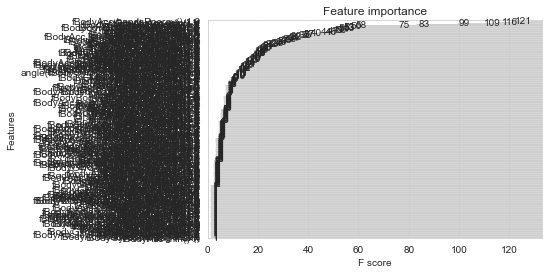

In [51]:
from xgboost import plot_importance, plot_tree

plot_importance(xgb_clf);

ImportError: You must install graphviz to plot tree

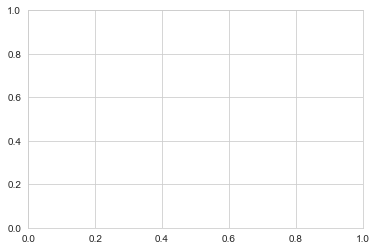

In [52]:
plot_tree(xgb_clf)

### LightGBM

* LightGBM의 메인 기술은 GOSS(Gradient-based One-Side Sampling)입니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdsAyLL%2FbtqXJWNRzgF%2FV0fFXLv9TXGJedlG20RIJK%2Fimg.png' width='700' />

<img src= 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fcarb0s%2FbtqXD29c4fG%2FpvFhJRHDUhdcGY0kU1fal1%2Fimg.png' widht='700' />

출처 : https://datascience.stackexchange.com/questions/26699/decision-trees-leaf-wise-best-first-and-level-wise-tree-traverse

* 일반 GBM 계열의 트리는 level-wise(균형 트리 분할) 방식을 채택합니다. 그림을 보시면 알겠지만 항상 균형을 이루며 2진 분할을 하고 있습니다.



* 반면 LightGBM에서 채택한 leaf-wise(리프 중심 트리 분할)은 트리가 깊어지면서 소요되는 시간과 메모리 모두를 절약 할 수 있었습니다.

LightGBM은 대용량에 특화 되어 있기 때문에 , 최소 10000건 이상에서 쓰기를 추천한다. 그렇지 않으면 , Overfitting이 일어나기 쉽다.

#### 파라미터 관련

|LightGBM|XGBoost|
|:-:|:-:|
|n_estmators|n_estmators|
|learning_rate|learning_rate|
|max_depth|max_depth|
|min_child_samples|N/A|
|subsample|subsample|
|colsample_bytree|colsample_bytree|
|reg_lambda|reg_lambda|
|reg_alpha|reg_alpha|
|eraly_stopping_rounds|eraly_stopping_rounds|
|num_leaves|N/A|
|min_child_weight|min_child_weight|


출처: http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/

위스콘신 유방함 예측 예제

In [53]:
from lightgbm import LGBMClassifier
from lightgbm import plot_importance, plot_metric, plot_tree

In [54]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state=156)

lgbm_clf = LGBMClassifier(n_estimators=400)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss',
             eval_set=evals, verbose=True)

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

LGBMClassifier(n_estimators=400)

In [55]:
preds = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)[:,1]

오차 행렬


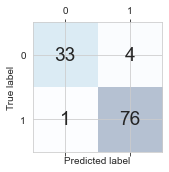

정확도:0.9561, 정밀도:0.9500, 재현율:0.9870, F1_score:0.9682,            AUC: 0.9905


In [56]:
get_clf_eval(y_test, preds, pred_proba)

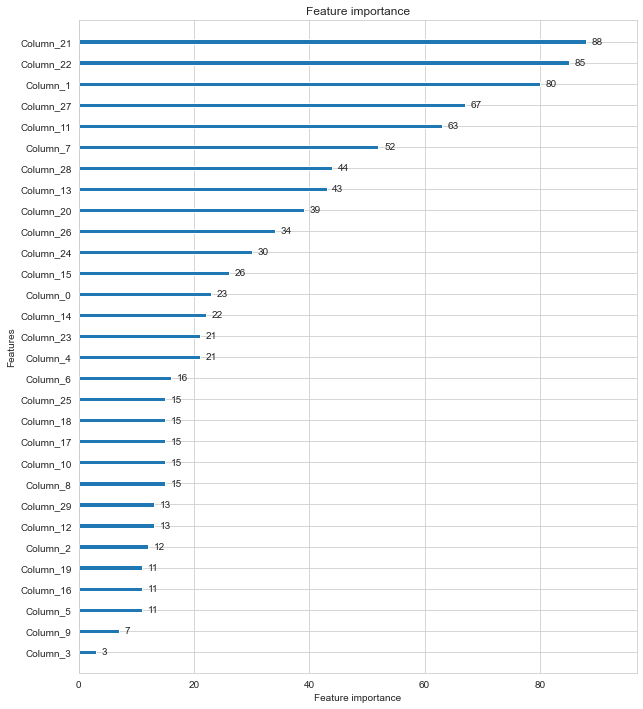

In [57]:
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_clf, ax=ax);

# Stacking

* 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행

* 즉, 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습을 수행

* 이를 기반으로 다시 최종 예측을 수행하는 방식.

* 이렇게 개별 모델의 예측된 데이터 세트를 다시 기반으로 하여 학습하고 예측하는 방식을 메타 모델

* 스태킹 모델은 두 종류의 모델이 필요하다. 
    - 첫번째 : 개별적인 기반 모델
    - 두번째 : 개별 기반 모델 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델.

* 스태킹 모델의 핵심 : 여러 개별 모델으 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것

* 스태킹 모델이 성능 향상을 보증 하지 않지만, 대회와 같이 조금이라도 성능 수치를 높여야 하는 경유에 유용함.



## Stacking Classifier

<img src='http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier_files/stackingclassification_overview.png' width='600' />

출처: http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/

### 날코딩

Data Load

In [58]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer= load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2, random_state=0)





model 

In [59]:
# 개별 모델
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델
lr_stacking = LogisticRegression()

학습

In [60]:
models = [knn_clf, rf_clf, dt_clf, ada_clf]

for model in models:
    model.fit(X_train, y_train)

정확도

In [61]:
pred_stacked = np.array([])
for model in models:
    pred = model.predict(X_test)
    if not pred_stacked.size:
        pred_stacked = pred[:, np.newaxis]
    else:
        pred_stacked = np.append(pred_stacked, pred[:,np.newaxis], axis=1)
    model_name = str(type(model)).split('.')[-1][:-2][:-len('crassifier')]
    print('{} acc: {:.4f}'.format(model_name, accuracy_score(y_test, pred)))

KNeighbors acc: 0.9211
RandomForest acc: 0.9649
DecisionTree acc: 0.9035
AdaBoost acc: 0.9561


In [62]:
pred_stacked.shape

(114, 4)

In [63]:
lr_stacking.fit(pred_stacked, y_test)
pred_final = lr_stacking.predict(pred_stacked)

print('Stacking Classifier acc {:.4f}'.format(accuracy_score(y_test, pred_final)))

Stacking Classifier acc 0.9737


### `sklearn.ensemble.StackingClassifier`

In [64]:
models

[KNeighborsClassifier(n_neighbors=4),
 RandomForestClassifier(random_state=0),
 DecisionTreeClassifier(),
 AdaBoostClassifier(n_estimators=100)]

In [65]:
from sklearn.ensemble import StackingClassifier

models = [('knn',knn_clf),
          ('rf',rf_clf),
          ('dt',dt_clf),
          ('ada',ada_clf)]

stc_clf = StackingClassifier(estimators=models,
                             final_estimator=LogisticRegression())

stc_clf.fit(X_train, y_train)

pred = stc_clf.predict(X_test)

print(accuracy_score(y_test, pred))

0.956140350877193


In [66]:
from sklearn.ensemble import StackingClassifier

models = [('knn',knn_clf),
          ('rf',rf_clf),
          ('dt',dt_clf),
          ('ada',ada_clf)]

stc_clf = StackingClassifier(estimators=models,
                             final_estimator=RandomForestClassifier())

stc_clf.fit(X_train, y_train)

pred = stc_clf.predict(X_test)

print(accuracy_score(y_test, pred))

0.956140350877193


비교: sklearn과 날코딩은 조금씩 값의 차이가 있지만, 과적합의 문제가 남아 있으니 다음 Stacking CV classifier에서 다시 자세히 다루어 보기로 하자.

## Stacking CV Classifier

<img src='http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier_files/stacking_cv_classification_overview.png' widht='500' />

출처 : http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/

### K_fold를 이용한 날코딩

In [67]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작', end='\t')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('#',folder_counter,end='')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 학습
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, 
    # test_pred_mean은 테스트 데이터
    print()
    return train_fold_pred, test_pred_mean  
    

In [68]:
Stack_final_X_train = np.array([])
Stack_final_X_test = np.array([])
models = [knn_clf, rf_clf, dt_clf, ada_clf]

for model in models:
    model_train, model_test = get_stacking_base_datasets(model, X_train, y_train, X_test, 7)
    if not Stack_final_X_train.size:
        Stack_final_X_train = model_train
    else: 
        Stack_final_X_train = np.append(Stack_final_X_train, model_train, axis=1)
    
    if not Stack_final_X_test.size:
        Stack_final_X_test = model_test
    else: 
        Stack_final_X_test = np.append(Stack_final_X_test, model_test, axis=1)

KNeighborsClassifier model 시작	# 0# 1# 2# 3# 4# 5# 6
RandomForestClassifier model 시작	# 0# 1# 2# 3# 4# 5# 6
DecisionTreeClassifier model 시작	# 0# 1# 2# 3# 4# 5# 6
AdaBoostClassifier model 시작	# 0# 1# 2# 3# 4# 5# 6


In [69]:
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


최종 모델

In [79]:
Stack_final_X_train

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [0., 1., 1., 1.],
       ...,
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 0., 1.]])

In [ ]:
X_train, y_train // X_test, y_test

In [70]:
lr_final = LogisticRegression()

lr_final.fit(Stack_final_X_train, y_train)

stack_final = lr_final.predict(Stack_final_X_test)

In [71]:
accuracy_score(y_test, stack_final)

0.9824561403508771

### `sklearn` 활용

In [72]:
models = [knn_clf, rf_clf, dt_clf, ada_clf]

models = [('knn',knn_clf),
          ('rf',rf_clf),
          ('dt',dt_clf),
          ('ada',ada_clf)]

In [73]:
stacking_clf = StackingClassifier(estimators=models,
                                  final_estimator=LogisticRegression(),
                          
                                  cv=7)

In [74]:
stacking_clf.fit(X_train, y_train)
stack_final = stacking_clf.predict(X_test)

In [75]:
accuracy_score(y_test, stack_final)

0.956140350877193

날코딩과 다소 차이가 나고 방식에도 차이가 있다. 
하지만 성능 을 보기에는 확실하게 빠른 `sklearn` 압승

# 앙상블 총평 

Voting, Bagging, Boosting, Stacking 이 4가지의 앙상블은 머신러닝의 핵심 중 하나인데, 실제로 많은 지식과 코드가 필요로 하다. 

단순히 sklearn을 활용하는 것을 넘어서 개념을 이해하고, 날코딩을 할수 있는 실력을 갖추는 것도 중요하다. 

**Reference**

* <a href='https://github.com/SeWonKwon' ><div> <img src ='https://slid-capture.s3.ap-northeast-2.amazonaws.com/public/image_upload/6556674324ed41a289a354258718280d/964e5a8b-75ad-41fc-ae75-0ca66d06fbc7.png' align='left' /> </div></a>

<br>

* 파이썬 머신러닝 완벽 가이드, 권철민
* [이수안 컴퓨터 연구소](http://suanlab.com/)
* https://velog.io/@jiselectric/Ensemble-Learning-Voting-and-Bagging-at6219ae
